In [82]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score,\
precision_recall_curve, roc_curve, roc_auc_score 
import itertools
from scipy.stats import iqr
from sklearn.preprocessing import StandardScaler

In [2]:
def create_column_pairs(columns, df=None, optimize=False, corr_thres=0.2):
    # creating pairs
    pairs = itertools.combinations(columns, 2)

    if optimize:
        corr = df.corr()
        corr_pairs = []
        for x, y in pairs:
            corr_value = corr.at[x, y]
            if not (corr_value < corr_thres) or not (corr_value > -corr_thres):
                corr_pairs.append({"x": x, "y": y, "corr": corr_value})

        return corr_pairs

    return list(pairs)

In [3]:
df = pd.read_csv("../datasets/diabetes.csv")

In [4]:
df.columns[:-1]

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')

In [5]:
cols_pairs =  create_column_pairs(df.columns[:-1])

In [6]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


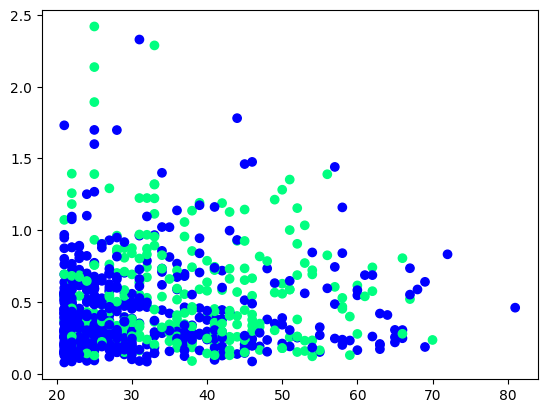

In [7]:
fig, ax = plt.subplots()

ax.scatter(df["Age"], df["DiabetesPedigreeFunction"], c=df["Outcome"], cmap='winter')

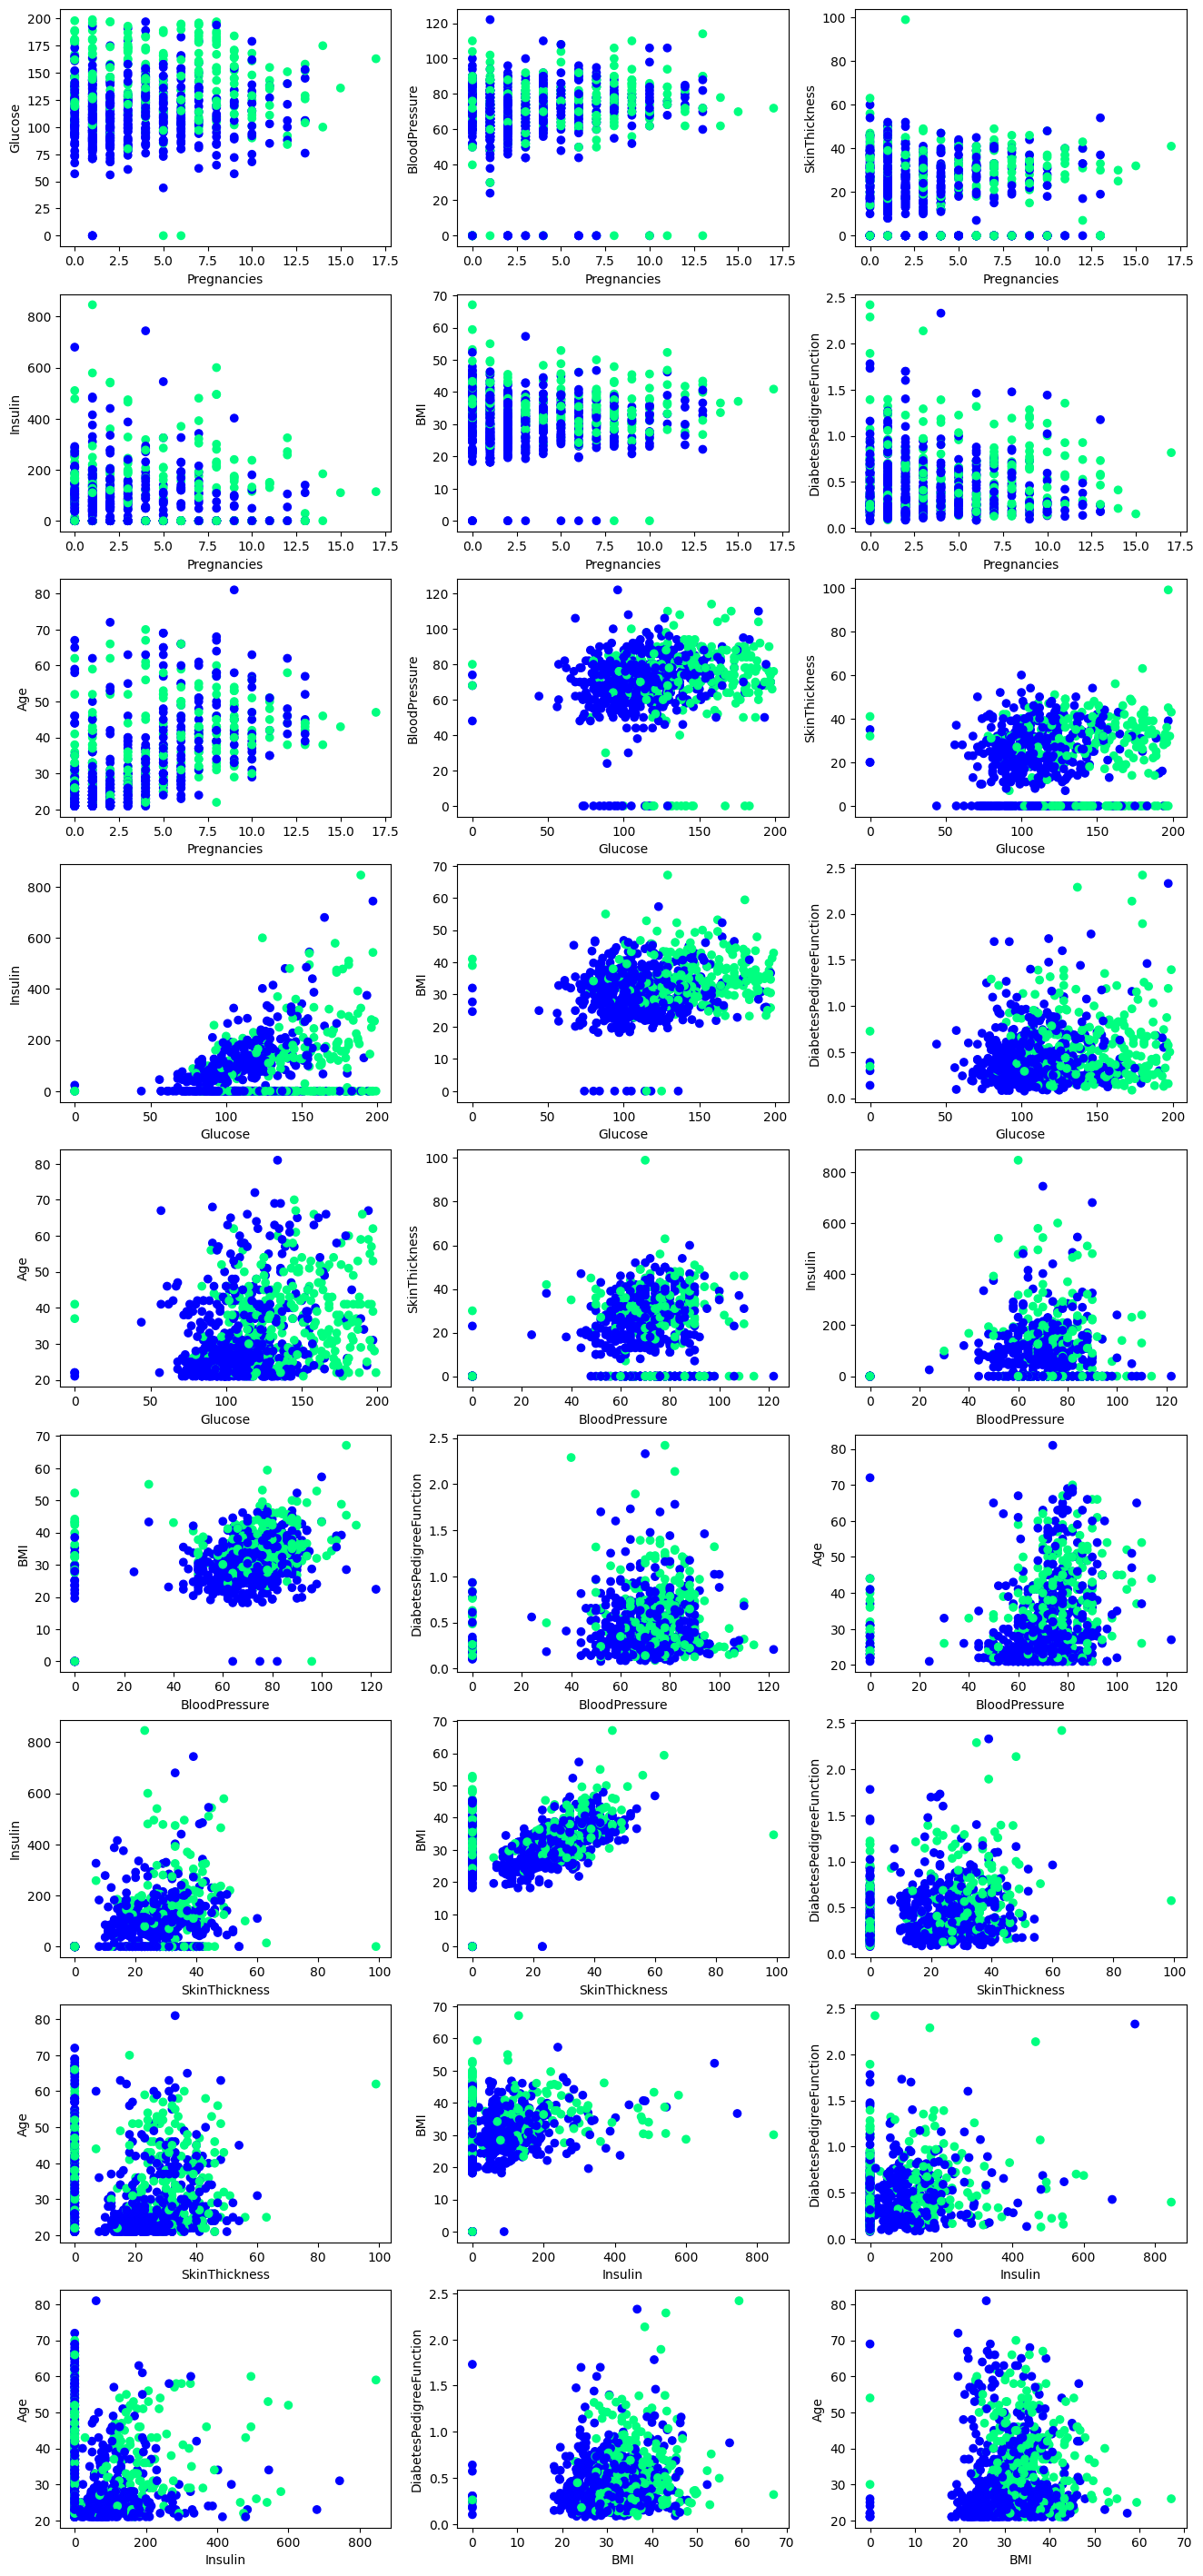

In [8]:
fig , axes = plt.subplots(figsize=(16, 4*9), nrows=9, ncols=3)

for ax, (x_col, y_col) in zip(axes.flat, cols_pairs):
    ax.scatter(df[x_col], df[y_col], c=df["Outcome"], cmap='winter')
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    

In [9]:
data_x = df.iloc[:, :-1]
data_y = df["Outcome"]

In [10]:
train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size=0.2)

In [11]:
lr = LogisticRegression(max_iter=1000)

In [12]:
lr.fit(train_x, train_y)

LogisticRegression(max_iter=1000)

In [13]:
y_pred =  lr.predict(test_x)

In [14]:
accuracy_score(test_y, y_pred)

0.8051948051948052

In [15]:
confusion_matrix(test_y, y_pred)

array([[92,  8],
       [22, 32]], dtype=int64)

In [16]:
cfm = ConfusionMatrixDisplay(confusion_matrix(test_y, y_pred), display_labels=["Negative", "Positive"])

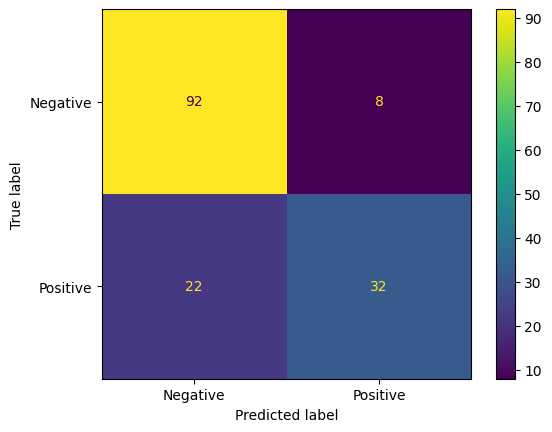

In [17]:
cfm.plot()

### Precision

$$Precision = \frac{TP}{TP+FP}$$

In [18]:
precision_score(test_y, y_pred)

0.8

### Recall

$$Recall = \frac{TP}{TP+FN}$$

In [19]:
recall_score(test_y, y_pred)

0.5925925925925926

### Calculating the probabilities of being positive

In [20]:
y_pred_prob =  cross_val_predict(lr, train_x, train_y, cv=3, method="decision_function")

In [21]:
precisions, recalls, thresholds =  precision_recall_curve(train_y, y_pred_prob)

In [22]:
precisions.shape, recalls.shape, thresholds.shape

((615,), (615,), (614,))

## Precision Recall on train_x

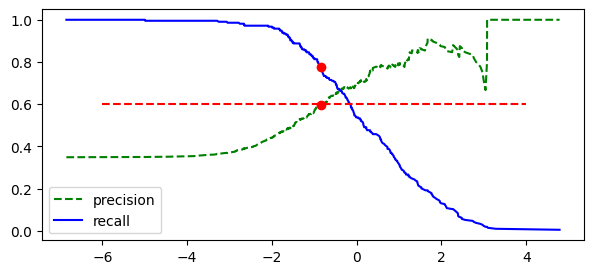

In [23]:
fig, ax = plt.subplots(figsize= (7,3))

threshold_60_precison_idx = np.argmax(precisions >= 0.5945945945945946)

ax.plot(thresholds, precisions[:-1], "--g", label="precision")
ax.plot(thresholds, recalls[:-1], "-b", label="recall")
ax.plot(thresholds[threshold_60_precison_idx], precisions[threshold_60_precison_idx], "ro")
ax.plot(thresholds[threshold_60_precison_idx], recalls[threshold_60_precison_idx], "ro")

ax.hlines(0.6, -6, 4, "red", '--')

ax.legend()

### ROC Curve and AUC

In [25]:
fpr, tpr, thresholds_ =  roc_curve(train_y, y_pred_prob)

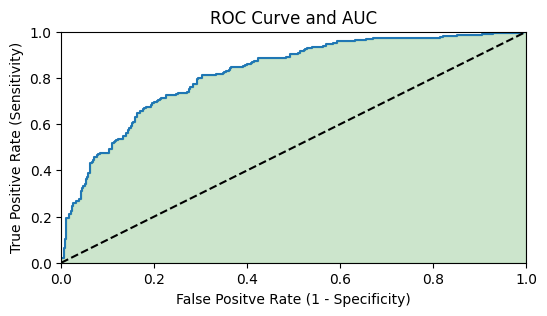

ROC's AUC Score:  0.8216705607476636


In [41]:
fig, ax = plt.subplots(figsize=(6,3))
ax.plot(fpr, tpr)
x = np.linspace(0,1,10)
ax.plot(x,x, "k--")
ax.axis([0,1,0,1])
ax.fill_between(fpr,tpr, alpha=0.2, color='green')
ax.set_xlabel("False Positve Rate (1 - Specificity)")
ax.set_ylabel("True Positive Rate (Sensitivity)")
ax.set_title("ROC Curve and AUC")
plt.show()

# calculating the ROC's AUC 
score_ = roc_auc_score(train_y, y_pred_prob)
print("ROC's AUC Score: ", score_)

[see more about fpr and tpr](https://en.wikipedia.org/wiki/Sensitivity_and_specificity)

## Optimizing the Model

#### 1. Remove the Outliers.

In [45]:
data_x.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


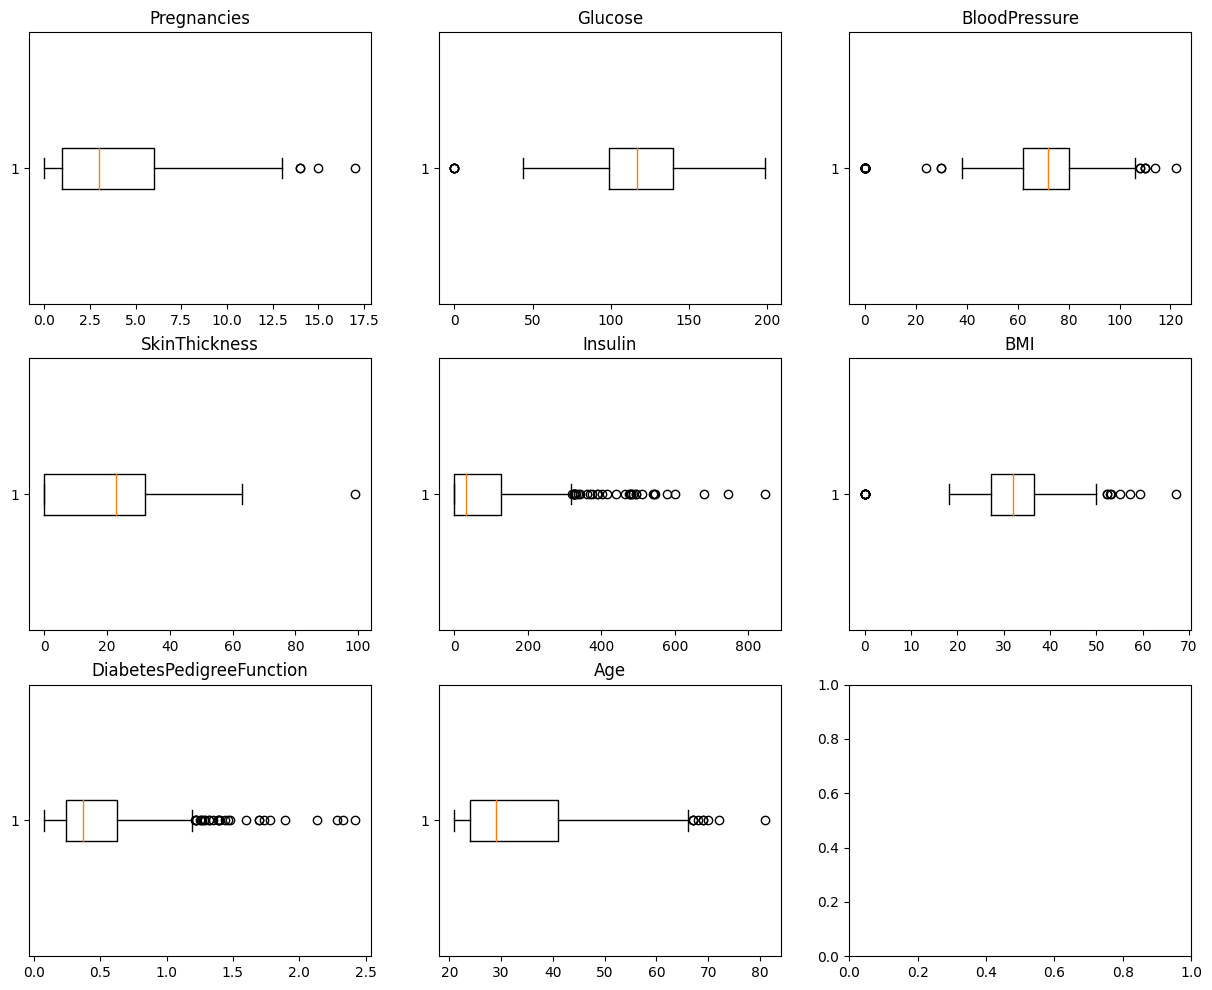

In [47]:
# plotting the outlier charts
fig, axes = plt.subplots(figsize = (15, 4*3), nrows=3, ncols=3)

for ax, col in zip(axes.flat, data_x.columns):
    ax.boxplot(data_x[col], vert=False)
    ax.set_title(col)

In [64]:
def iqr_values(df, threshold=1.5):

    result = []
    for col in df.columns:
        series = df[col]
        summary = {
            "iqr":iqr(df[col]),
            "Q1": np.percentile(df[col], 25),
            "Q3": np.percentile(df[col], 75)}

        summary["lw"] = summary["Q1"] - threshold * summary["iqr"]
        summary["uw"] = summary["Q3"] + threshold * summary["iqr"]
        
        result.append((col, summary))
    return result

In [65]:
iqr_vals =  iqr_values(data_x)

In [66]:
iqr_vals

[('Pregnancies', {'iqr': 5.0, 'Q1': 1.0, 'Q3': 6.0, 'lw': -6.5, 'uw': 13.5}),
 ('Glucose',
  {'iqr': 41.25, 'Q1': 99.0, 'Q3': 140.25, 'lw': 37.125, 'uw': 202.125}),
 ('BloodPressure',
  {'iqr': 18.0, 'Q1': 62.0, 'Q3': 80.0, 'lw': 35.0, 'uw': 107.0}),
 ('SkinThickness',
  {'iqr': 32.0, 'Q1': 0.0, 'Q3': 32.0, 'lw': -48.0, 'uw': 80.0}),
 ('Insulin',
  {'iqr': 127.25, 'Q1': 0.0, 'Q3': 127.25, 'lw': -190.875, 'uw': 318.125}),
 ('BMI',
  {'iqr': 9.3, 'Q1': 27.3, 'Q3': 36.6, 'lw': 13.35, 'uw': 50.550000000000004}),
 ('DiabetesPedigreeFunction',
  {'iqr': 0.38249999999999995,
   'Q1': 0.24375,
   'Q3': 0.62625,
   'lw': -0.32999999999999996,
   'uw': 1.2}),
 ('Age', {'iqr': 17.0, 'Q1': 24.0, 'Q3': 41.0, 'lw': -1.5, 'uw': 66.5})]

In [77]:
def capping(df, iqr_vals):
    result = {}
    for col, item in iqr_vals:
        lw, uw = item["lw"], item["uw"]
        xx = np.where(df[col] < lw, lw, 
         np.where(df[col] > uw, uw, df[col])
        )
        result.update({col: xx})

    return pd.DataFrame(result)

In [80]:
capped_df =  capping(data_x, iqr_vals)

In [81]:
capped_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0
1,1.0,85.0,66.0,29.0,0.0,26.6,0.351,31.0
2,8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0
4,0.0,137.0,40.0,35.0,168.0,43.1,1.200,33.0
...,...,...,...,...,...,...,...,...
763,10.0,101.0,76.0,48.0,180.0,32.9,0.171,63.0
764,2.0,122.0,70.0,27.0,0.0,36.8,0.340,27.0
765,5.0,121.0,72.0,23.0,112.0,26.2,0.245,30.0
766,1.0,126.0,60.0,0.0,0.0,30.1,0.349,47.0


### boxplots after capping the outliers

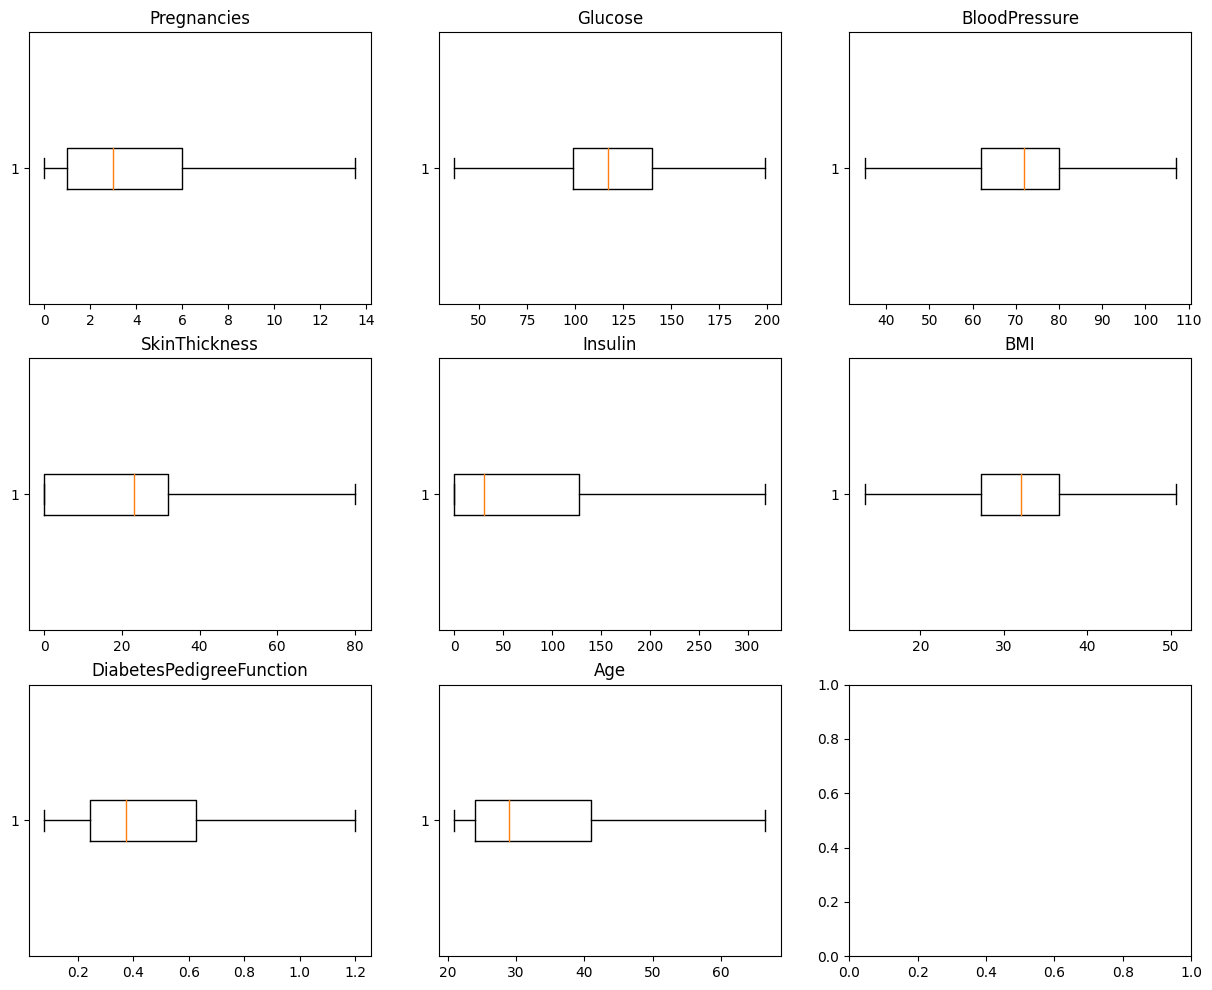

In [83]:
fig, axes = plt.subplots(figsize = (15, 4*3), nrows=3, ncols=3)

for ax, col in zip(axes.flat, capped_df.columns):
    ax.boxplot(capped_df[col], vert=False)
    ax.set_title(col)

### Applying the Standard Scalling

In [84]:
scaler = StandardScaler()

In [85]:
new_df = scaler.fit_transform(capped_df)

In [86]:
new_df

array([[ 0.64714967,  0.86192556,  0.09269135, ...,  0.20935933,
         0.58892732,  1.44569096],
       [-0.84896998, -1.15943299, -0.33020145, ..., -0.78425421,
        -0.37810147, -0.189304  ],
       [ 1.24559754,  1.98490253, -0.47116571, ..., -1.25267202,
         0.74659506, -0.10325164],
       ...,
       [ 0.34792574, -0.00437096,  0.09269135, ..., -0.84103213,
        -0.74949659, -0.27535637],
       [-0.84896998,  0.15605432, -0.75309424, ..., -0.28744744,
        -0.38510892,  1.18753386],
       [-0.84896998, -0.90275254, -0.04827292, ..., -0.24486401,
        -0.50423566, -0.87772293]])

### Creating a New model

In [88]:
lr = LogisticRegression(max_iter=1000)

In [95]:
y_pred = cross_val_predict(lr, new_df, data_y, cv=5, method="decision_function")
precisions, recalls, thresholds =  precision_recall_curve(data_y, y_pred)

**accuracy_score**

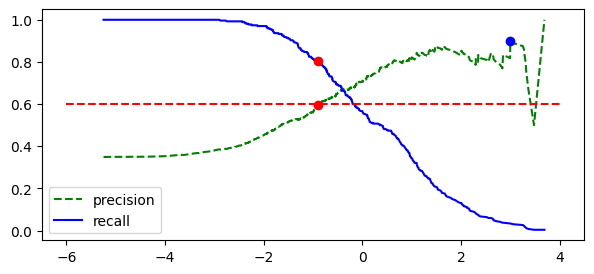

In [106]:
fig, ax = plt.subplots(figsize= (7,3))

threshold_60_precison_idx = np.argmax(precisions >= 0.5945945945945946)
threshold_90_precison_idx = np.argmax(precisions >= 0.90)

ax.plot(thresholds, precisions[:-1], "--g", label="precision")
ax.plot(thresholds, recalls[:-1], "-b", label="recall")
ax.plot(thresholds[threshold_60_precison_idx], precisions[threshold_60_precison_idx], "ro")
ax.plot(thresholds[threshold_60_precison_idx], recalls[threshold_60_precison_idx], "ro")
ax.plot(thresholds[threshold_90_precison_idx], precisions[threshold_90_precison_idx], "bo")
ax.hlines(0.6, -6, 4, "red", '--')

ax.legend()

**ROC Curve and AUC**

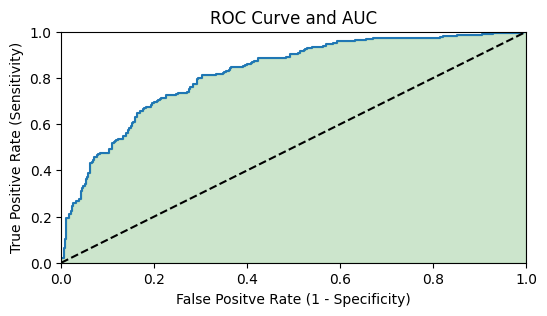

ROC's AUC Score:  0.8339850746268657


In [98]:
fpr, tpr, thresholds_ =  roc_curve(train_y, y_pred_prob)

fig, ax = plt.subplots(figsize=(6,3))
ax.plot(fpr, tpr)
x = np.linspace(0,1,10)
ax.plot(x,x, "k--")
ax.axis([0,1,0,1])
ax.fill_between(fpr,tpr, alpha=0.2, color='green')
ax.set_xlabel("False Positve Rate (1 - Specificity)")
ax.set_ylabel("True Positive Rate (Sensitivity)")
ax.set_title("ROC Curve and AUC")
plt.show()

# calculating the ROC's AUC 
score_ = roc_auc_score(data_y, y_pred)
print("ROC's AUC Score: ", score_)

In [100]:
y_predicted =  cross_val_predict(lr, new_df, data_y, cv=5)

In [101]:
accuracy_score(data_y, y_predicted)

0.765625

In [104]:
np.argmax(precisions >= .90)

758

In [105]:
precisions[758]

0.9